In [1]:
!mkdir ./src
!mkdir ./src/Components
!mkdir ./src/Components/XRP
!mkdir ./public
!mkdir ./public/XRP

In [2]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime
from tensorflow.keras.models import load_model

In [3]:
def merge_sentimental_data(sentimental_data_file_path, XRP_data):
  # Load sentimental data in csv
  sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
  zeros = pd.DataFrame([0]*21)
  sentiment_data = pd.concat([zeros, sentiment_data], ignore_index=True)
  # Merge with XRP quant
  merged_data = pd.concat([XRP_data, sentiment_data], axis=1)
  num_rows = len(XRP_data)
  new_data_adjusted = pd.DataFrame([0] * num_rows, index=XRP_data.index)
  new_data_adjusted.iloc[-len(sentiment_data):] = sentiment_data.values
  merged_data = pd.concat([XRP_data, new_data_adjusted], axis=1)
  merged_data.columns = list(XRP_data.columns) + ['sentiment']
  return merged_data

In [4]:
### The code below is for dataset that merge sentimental data ONLY
### The code will be commented until the sentimental data is fetched
def predict(num_days_to_predict, sentimental_data_file_path):
    # Load model, prediction csv
    model_path = './XRP_model.h5'
    model = load_model(model_path)
    prediction_path = './XRP_prediction.csv'
    prediction = pd.read_csv(prediction_path)
    error = prediction.iloc[-1, 0] - prediction.iloc[-1, 1]
    ### Fetch XRP-USD data BEGIN ###
    ### CHANGE THIS TO THE FUNCTION USING PYSPARK ###
    today = datetime.date.today()
    XRP_quant = yf.download('XRP-USD', start=today-datetime.timedelta(days=365), end=today)
    ### Fetch XRP-USD data END ###
    new_df=XRP_quant.filter(['Adj Close'])
    # Merge sentimental data
    merged_data = merge_sentimental_data(sentimental_data_file_path, new_df)
    # Create 30 window days slot
    last_30_days = merged_data[-30:].values
    last_30_days_price = merged_data['Adj Close'][-30:].values.reshape(-1, 1)
    last_30_days_sentiment = merged_data['sentiment'][-30:].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    last_30_days_scaled_price = scaler.fit_transform(last_30_days_price)
    sentiment_data = pd.read_csv(sentimental_data_file_path).iloc[:, 1]
    sentiment_values = sentiment_data.values.reshape(-1, 1)
    scaler_sentiment = MinMaxScaler()
    scaled_sentiment = scaler_sentiment.fit_transform(sentiment_values)
    last_30_days_scaled_sentiment = scaler_sentiment.transform(last_30_days_sentiment)
    predictions = []
    predicted_dates = []
    # Predict price
    for _ in range(num_days_to_predict):
        offset = error*(0.5-0.03*_)
        if (offset<0):
          offset = 0
        last_date = merged_data.index[-1]
        X_test = []
        X_test.append(np.hstack((last_30_days_scaled_price.flatten(), last_30_days_scaled_sentiment.flatten())))
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        pred_price = model.predict(X_test)
        pred_price_unscaled = scaler.inverse_transform(pred_price)
        predictions.append(pred_price_unscaled[0][0]+offset)
        last_30_days_scaled_price = np.concatenate((last_30_days_scaled_price[1:], pred_price), axis=0)
        predicted_date = last_date + datetime.timedelta(days=_+1)
        predicted_dates.append(predicted_date)
    # print(f"Price of XRP-USD for the next {num_days_to_predict} trading days: {predictions}")
    output_text = f"Price of XRP-USD for the next {num_days_to_predict} trading days: {predictions}"
    print(output_text)
    file_name = f"./public/XRP/Prediction_{num_days_to_predict}days.txt"
    with open(file_name, 'w') as file:
      file.write(output_text)
    fig, ax = plt.subplots()
    ax.plot(predicted_dates, predictions, marker='o', label='Predicted Prices')
    ax.set(xlabel='Date', ylabel='XRP-USD Price', title=f'Predicted XRP-USD Prices for the Next {num_days_to_predict} Trading Days')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax.set_xlim(predicted_dates[0] - datetime.timedelta(days=2), predicted_dates[0] + datetime.timedelta(days=num_days_to_predict+3))
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.savefig(f'./src/Components/XRP/Prediction_{num_days_to_predict}days', dpi=300, bbox_inches='tight')
    plt.show()


[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 7s 7s/step
Price of XRP-USD for the next 1 trading days: [0.4893089514274597]


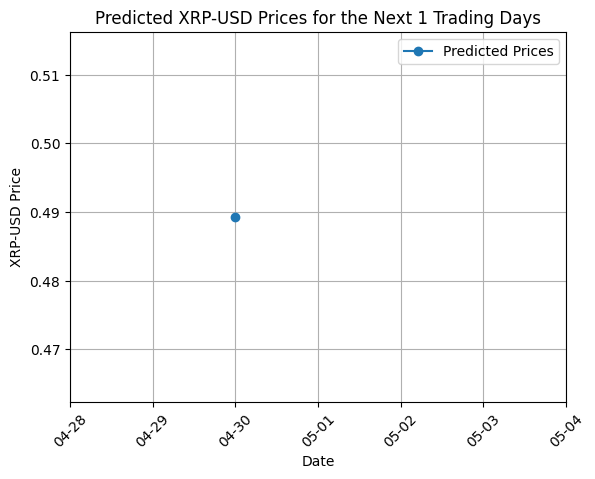

In [5]:
sentimental_data_file_path = './XRP_vader.csv'
predict(1, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 38ms/step
Price of XRP-USD for the next 3 trading days: [0.4893089514274597, 0.49468757991207124, 0.5025758023603057]


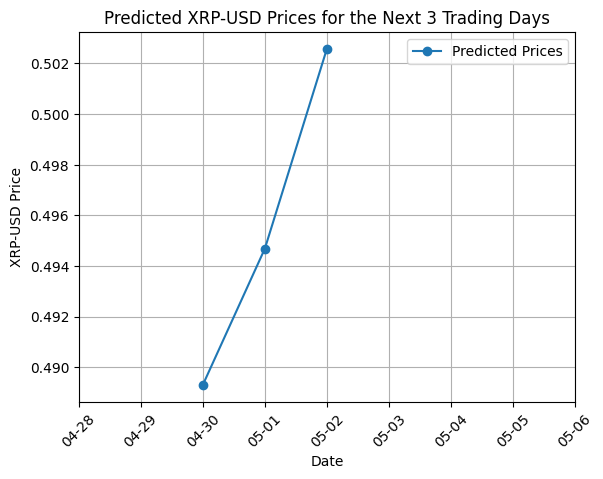

In [6]:
predict(3, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 21ms/step
Price of XRP-USD for the next 5 trading days: [0.4893089514274597, 0.49468757991207124, 0.5025758023603057, 0.5093270364071274, 0.5154680082984161]


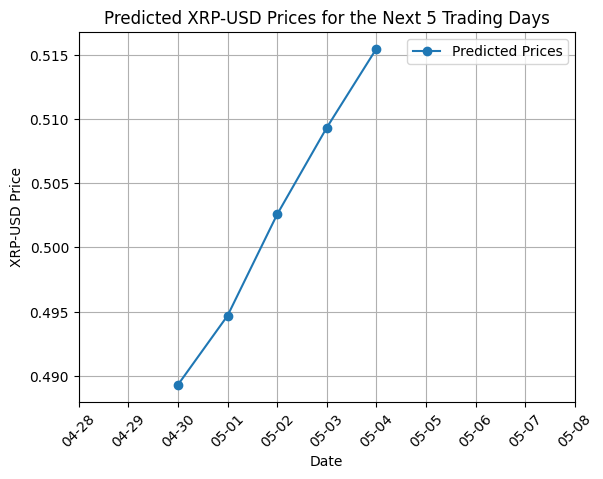

In [7]:
predict(5, sentimental_data_file_path)

[*********************100%***********************]  1 of 1 completed
1/1 [==============================] - 0s 22ms/step
Price of XRP-USD for the next 30 trading days: [0.4893089514274597, 0.49468757991207124, 0.5025758023603057, 0.5093270364071274, 0.5154680082984161, 0.5224137024988175, 0.5287712180645752, 0.5313543887092209, 0.5313389756555938, 0.5308953032292557, 0.5304803602416992, 0.5300769209505845, 0.529670441822586, 0.5292687906708146, 0.5288592121012878, 0.5284318117429734, 0.5280007158966827, 0.5277147889137268, 0.5276991128921509, 0.5276594161987305, 0.5276265144348145, 0.5275946259498596, 0.5275631546974182, 0.5275301933288574, 0.5274972915649414, 0.5274657011032104, 0.5274366736412048, 0.5274113416671753, 0.5273904800415039, 0.5273739695549011]


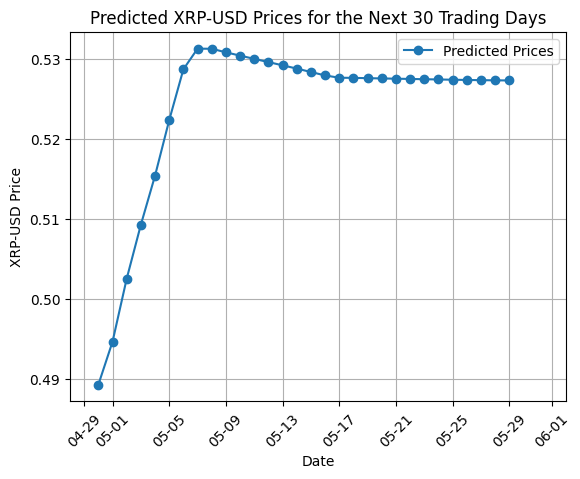

In [8]:
predict(30, sentimental_data_file_path)